# Antibiotic Resistance Gene Mobility Analysis

This notebook performs a comprehensive data-driven analysis of antibiotic resistance genes (ARGs) from the CARD database to predict horizontal gene transfer (HGT) risk.

## Workflow Overview:
1. **Data Loading**: Import metadata and protein sequences from CARD
2. **Data Preprocessing**: Clean and merge datasets
3. **Exploratory Data Analysis**: Visualize distributions and patterns
4. **Feature Engineering**: Extract mobility-related features
5. **Machine Learning**: Apply PCA and clustering algorithms
6. **Mobility Scoring**: Rank genes by transfer potential
7. **Results Interpretation**: Identify high-risk mobile ARGs

## Step 1: Install Required Dependencies

Installing essential Python packages for:
- **BioPython**: Sequence parsing and analysis
- **XGBoost**: Gradient boosting for classification
- **UMAP**: Dimensionality reduction
- **Matplotlib/Seaborn**: Data visualization
- **Scikit-learn**: Machine learning algorithms

In [1]:
!pip install biopython xgboost umap-learn matplotlib seaborn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 46.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 74.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.2 which is incompatible.


## Step 2: Install ESM Protein Language Model

Installing the ESM (Evolutionary Scale Modeling) protein language model for generating sequence embeddings. This enables deep learning-based protein representation.

In [2]:
!pip install fair-esm biopython transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 4.1 MB/s eta 0:00:00


## Step 3: Import Libraries

Loading all necessary libraries for data processing, machine learning, and visualization.

In [3]:
import os
import pandas as pd
import numpy as np
from Bio import SeqIO

import torch
import esm

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import plotly.express as px


## Step 4: Explore CARD Metadata Structure

Examining the columns available in the ARO (Antibiotic Resistance Ontology) index to understand the data structure.

In [4]:
import pandas as pd

metadata_path = "/kaggle/input/card-data/aro_index.tsv"

df = pd.read_csv(metadata_path, sep="\t")
print(df.columns)

Index(['ARO Accession', 'CVTERM ID', 'Model Sequence ID', 'Model ID',
       'Model Name', 'ARO Name', 'Protein Accession', 'DNA Accession',
       'AMR Gene Family', 'Drug Class', 'Resistance Mechanism',
       'CARD Short Name'],
      dtype='object')


## Step 5: Load and Clean Metadata

Loading the ARO index with selected columns containing:
- ARO Accession numbers (gene IDs)
- Gene names and protein accessions
- AMR gene families
- Drug classes and resistance mechanisms

Cleaning the ARO Accession field by extracting numeric IDs for easier merging.

In [5]:
metadata_path = "/kaggle/input/card-data/aro_index.tsv"

df_meta = pd.read_csv(metadata_path, sep="\t", usecols=[
    "ARO Accession",
    "ARO Name",
    "Protein Accession",
    "AMR Gene Family",
    "Drug Class",
    "Resistance Mechanism"
])

# Convert ARO Accession into pure numeric ID (extract digits)
df_meta["ARO Accession"] = (
    df_meta["ARO Accession"]
    .astype(str)
    .str.extract(r"(\d+)")
)

df_meta.dropna(subset=["ARO Accession"], inplace=True)
df_meta["ARO Accession"] = df_meta["ARO Accession"].astype(str)


## Step 6: Parse Protein Sequences from FASTA

Reading protein sequences from the CARD homolog model FASTA file. Extracting ARO accession numbers from sequence headers using regex pattern matching.

In [6]:
fasta_path = "/kaggle/input/card-data/protein_fasta_protein_homolog_model.fasta"

records = list(SeqIO.parse(fasta_path, "fasta"))

import re

seqs = []

for r in records:
    # Extract ARO numeric ID from header
    match = re.search(r"ARO:(\d+)", r.description)
    if match:
        aro = match.group(1)
        seqs.append({"ARO Accession": aro, "sequence": str(r.seq)})

df_seq = pd.DataFrame(seqs)

df = df_meta.merge(df_seq, on="ARO Accession", how="inner")
df.head()
print(df.shape)



(6054, 7)


## Step 7: Examine FASTA Header Format

Inspecting the structure of FASTA headers to determine the correct pattern for ARO accession extraction.

In [7]:
from Bio import SeqIO

fasta_path = "/kaggle/input/card-data/protein_fasta_protein_homolog_model.fasta"

for r in SeqIO.parse(fasta_path, "fasta"):
    print(r.id)
    print(r.description)
    break


gb|ACT97415.1|ARO:3002999|CblA-1
gb|ACT97415.1|ARO:3002999|CblA-1 [mixed culture bacterium AX_gF3SD01_15]


## Step 8: Robust ARO Accession Extraction

Using multiple regex patterns to handle different FASTA header formats and extract ARO accession numbers reliably.

In [8]:
import re

records = list(SeqIO.parse(fasta_path, "fasta"))

seqs = []

for r in records:
    desc = r.description

    # Try extracting different possible ARO accession formats
    aro_numeric = re.findall(r"ARO:?_?(\d+)", desc)
    aro_pipe = re.findall(r"(\d+)\|", desc)
    aro_before_space = r.id.split(".")[0]  # part before dot

    if aro_numeric:
        aro = aro_numeric[0]
    elif aro_pipe:
        aro = aro_pipe[0]
    else:
        aro = aro_before_space

    seqs.append({"ARO Accession": aro, "sequence": str(r.seq)})

df_seq = pd.DataFrame(seqs)

print(df_seq.head())
print(df_seq.shape)


  ARO Accession                                           sequence
0       3002999  MKAYFIAILTLFTCIATVVRAQQMSELENRIDSLLNGKKATVGIAV...
1       3001109  MRYIRLCIISLLAALPLAVHASPQPLEQIKQSESQLSGRVGMIEMD...
2       3002867  MIGLIVARSKNNVIGKNGNIPWKIKGEQKQFRELTTGNVVIMGRKS...
3       3001989  MVTKRVQRMMFAAAACIPLLLGSAPLYAQTSAVQQKLAALEKSSGG...
4       3002356  MELPNIMHPVAKLSTALAAALMLSGCMPGEIRPTIGQQMETGDQRF...
(6052, 2)


## Step 9: Merge Metadata and Sequences

Performing an inner join between metadata and sequence dataframes on ARO Accession to create a unified dataset containing both biological annotations and protein sequences.

In [9]:
df = df_meta.merge(df_seq, on="ARO Accession", how="inner")

print(df.shape)
df.head()


(6053, 7)


,ARO Accession,ARO Name,Protein Accession,AMR Gene Family,Drug Class,Resistance Mechanism,sequence
0,3005099,23S rRNA (adenine(2058)-N(6))-methyltransferas...,AAB60941.1,Erm 23S ribosomal RNA methyltransferase,lincosamide antibiotic;macrolide antibiotic;st...,antibiotic target alteration,MKQKNPKNTQNFITSKKHVKEILKYTNINKQDKIIEIGSGKGHFTK...
1,3002523,AAC(2')-Ia,AAA03550.1,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,MGIEYRSLHTSQLTLSEKEALYDLLIEGFEGDFSHDDFAHTLGGMH...
2,3002524,AAC(2')-Ib,AAC44793.1,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,MPFQDVSAPVRGGILHTARLVHTSDLDQETREGARRMVIEAFEGDF...
3,3002525,AAC(2')-Ic,CCP42991.1,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,MHTQVHTARLVHTADLDSETRQDIRQMVTGAFAGDFTETDWEHTLG...
4,3002526,AAC(2')-Id,AAB41701.1,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,MLTQHVSEARTRGAIHTARLIHTSDLDQETRDGARRMVIEAFRDPS...


## Step 10: Basic Exploratory Data Analysis

Displaying dataset dimensions and preview to understand the structure of our merged ARG dataset.

In [10]:
# -------------------------------------------------------------
#              ✅ BASIC EDA ON CARD META + SEQUENCES
# -------------------------------------------------------------

print("Rows:", df.shape)
df.head()


Rows: (6053, 7)


,ARO Accession,ARO Name,Protein Accession,AMR Gene Family,Drug Class,Resistance Mechanism,sequence
0,3005099,23S rRNA (adenine(2058)-N(6))-methyltransferas...,AAB60941.1,Erm 23S ribosomal RNA methyltransferase,lincosamide antibiotic;macrolide antibiotic;st...,antibiotic target alteration,MKQKNPKNTQNFITSKKHVKEILKYTNINKQDKIIEIGSGKGHFTK...
1,3002523,AAC(2')-Ia,AAA03550.1,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,MGIEYRSLHTSQLTLSEKEALYDLLIEGFEGDFSHDDFAHTLGGMH...
2,3002524,AAC(2')-Ib,AAC44793.1,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,MPFQDVSAPVRGGILHTARLVHTSDLDQETREGARRMVIEAFEGDF...
3,3002525,AAC(2')-Ic,CCP42991.1,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,MHTQVHTARLVHTADLDSETRQDIRQMVTGAFAGDFTETDWEHTLG...
4,3002526,AAC(2')-Id,AAB41701.1,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,MLTQHVSEARTRGAIHTARLIHTSDLDQETRDGARRMVIEAFRDPS...


## Step 11: Check for Missing Values

Identifying missing data across all columns to ensure data quality and completeness.

In [11]:
df.isna().sum()


ARO Accession           0
ARO Name                0
Protein Accession       0
AMR Gene Family         0
Drug Class              0
Resistance Mechanism    0
sequence                0
dtype: int64

## Step 12: Visualize Drug Class Distribution

**Analysis**: This bar chart shows the top 20 most common drug classes in the CARD database. Understanding drug class distribution helps identify which antibiotics are most affected by resistance genes. High counts indicate widespread resistance mechanisms against specific drug types.

/tmp/ipykernel_48/2759287809.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


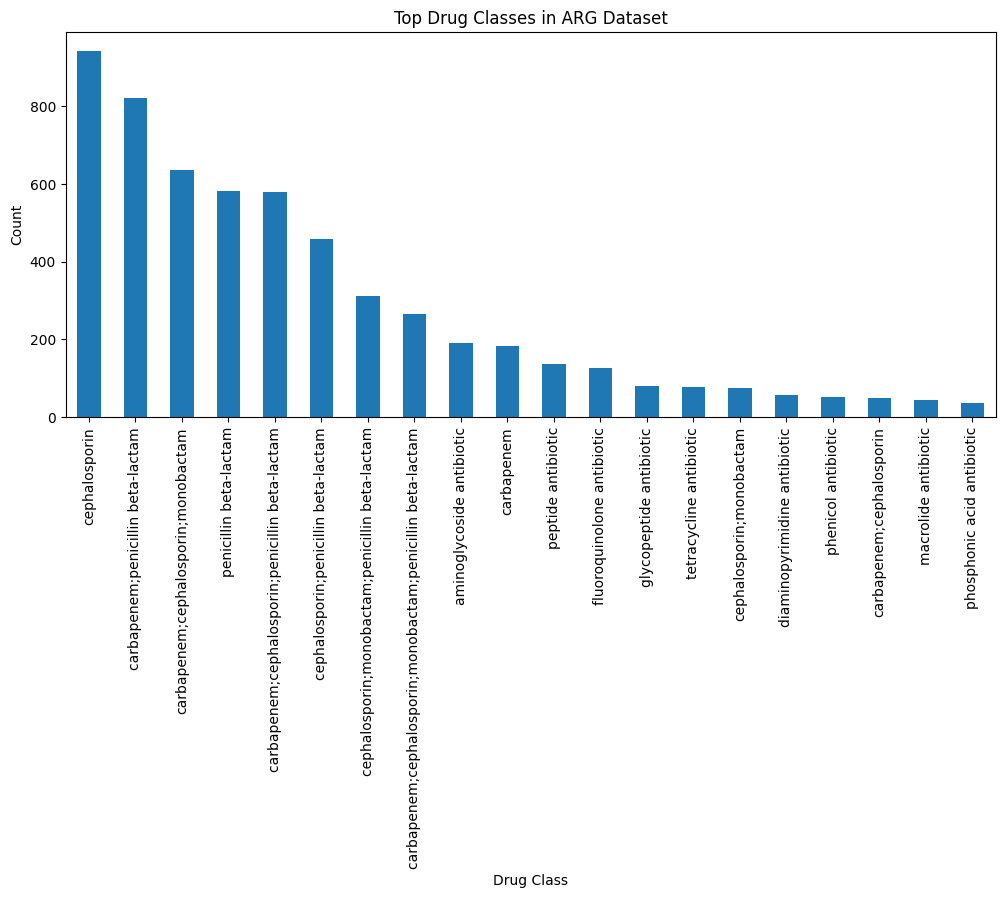

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
df["Drug Class"].value_counts().head(20).plot(kind="bar")
plt.title("Top Drug Classes in ARG Dataset")
plt.xlabel("Drug Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


## Step 13: Resistance Mechanism Analysis

**Analysis**: This visualization displays the most prevalent resistance mechanisms employed by bacteria. Common mechanisms include:
- **Efflux pumps**: Actively transport antibiotics out of cells
- **Target modification**: Alter antibiotic binding sites
- **Enzymatic inactivation**: Degrade or modify antibiotics

Understanding mechanism prevalence helps prioritize mobility analysis for high-impact resistance strategies.

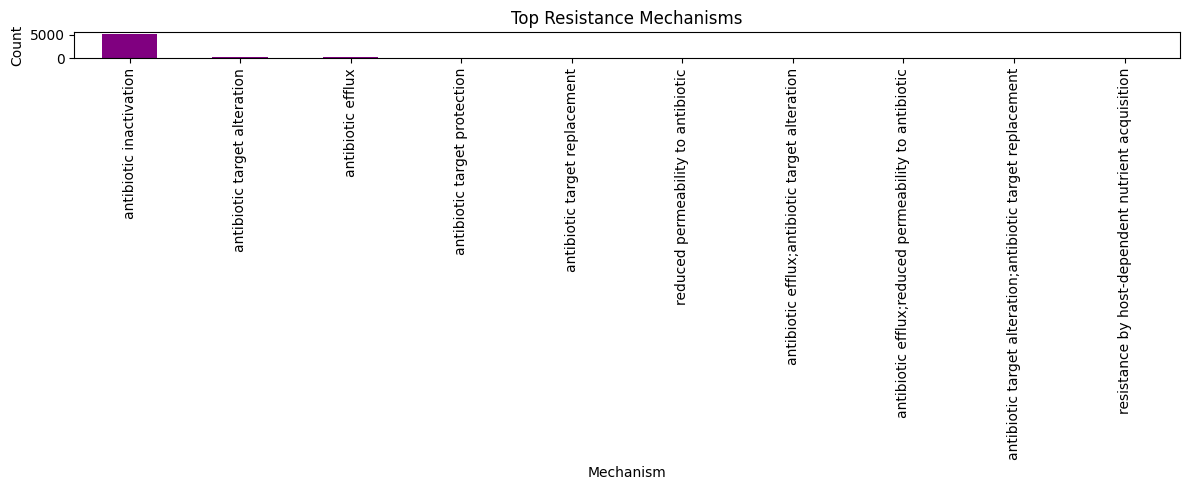

In [13]:
plt.figure(figsize=(12,5))
df["Resistance Mechanism"].value_counts().head(20).plot(kind="bar", color="purple")
plt.title("Top Resistance Mechanisms")
plt.xlabel("Mechanism")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


## Step 14: AMR Gene Family Distribution

**Analysis**: This chart reveals the most abundant ARG families in the database. Gene families like beta-lactamases, aminoglycoside-modifying enzymes, and multidrug efflux pumps are critical for tracking because:
- They often reside on mobile genetic elements
- They confer resistance to multiple antibiotics
- They are frequently transferred between species

/tmp/ipykernel_48/1660021390.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


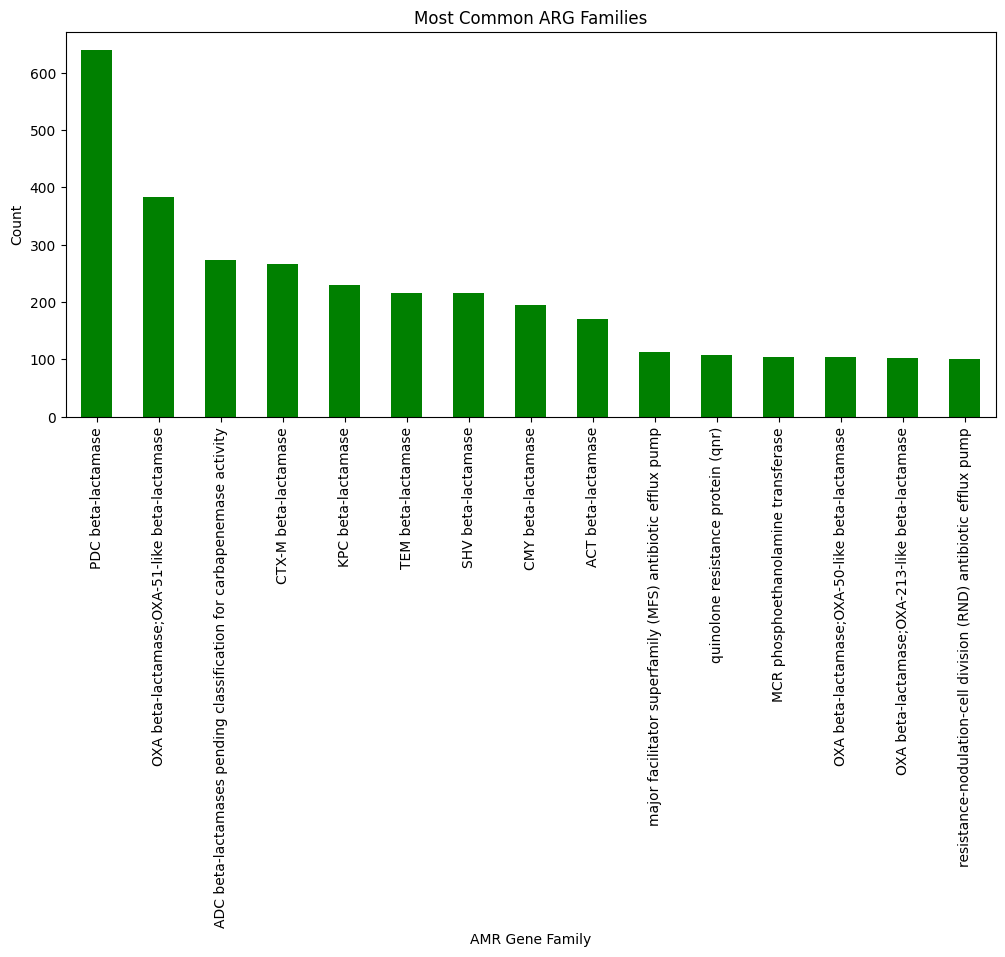

In [14]:
plt.figure(figsize=(12,5))
df["AMR Gene Family"].value_counts().head(15).plot(kind="bar", color="green")
plt.title("Most Common ARG Families")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


## Step 15: Protein Sequence Length Distribution

**Analysis**: This histogram shows the distribution of protein sequence lengths in amino acids. 

**Key Insights**:
- Shorter sequences (<300 aa) are often more mobile and easier to transfer
- Longer sequences (>500 aa) may be chromosomally encoded and less mobile
- The distribution shape indicates diversity in resistance gene architectures
- Bimodal distributions might suggest different functional classes

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


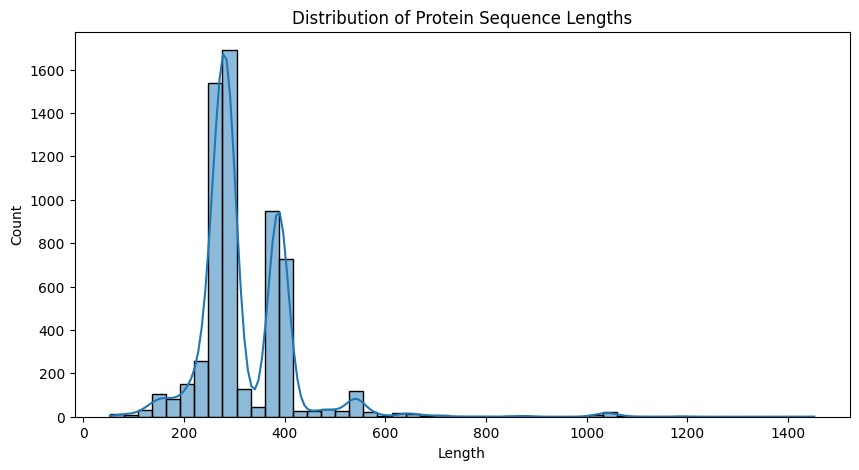

In [15]:
df["seq_len"] = df["sequence"].str.len()

plt.figure(figsize=(10,5))
sns.histplot(df["seq_len"], bins=50, kde=True)
plt.title("Distribution of Protein Sequence Lengths")
plt.xlabel("Length")
plt.show()


## Step 16: Feature Engineering and PCA Visualization

Creating encoded features from categorical variables (gene family, drug class, mechanism) and combining with sequence length. Applying PCA to reduce dimensions to 2D for visualization.

**Analysis**: The PCA scatter plot reveals natural groupings of ARGs based on their biological properties. Clusters indicate genes with similar characteristics that may share mobility patterns.

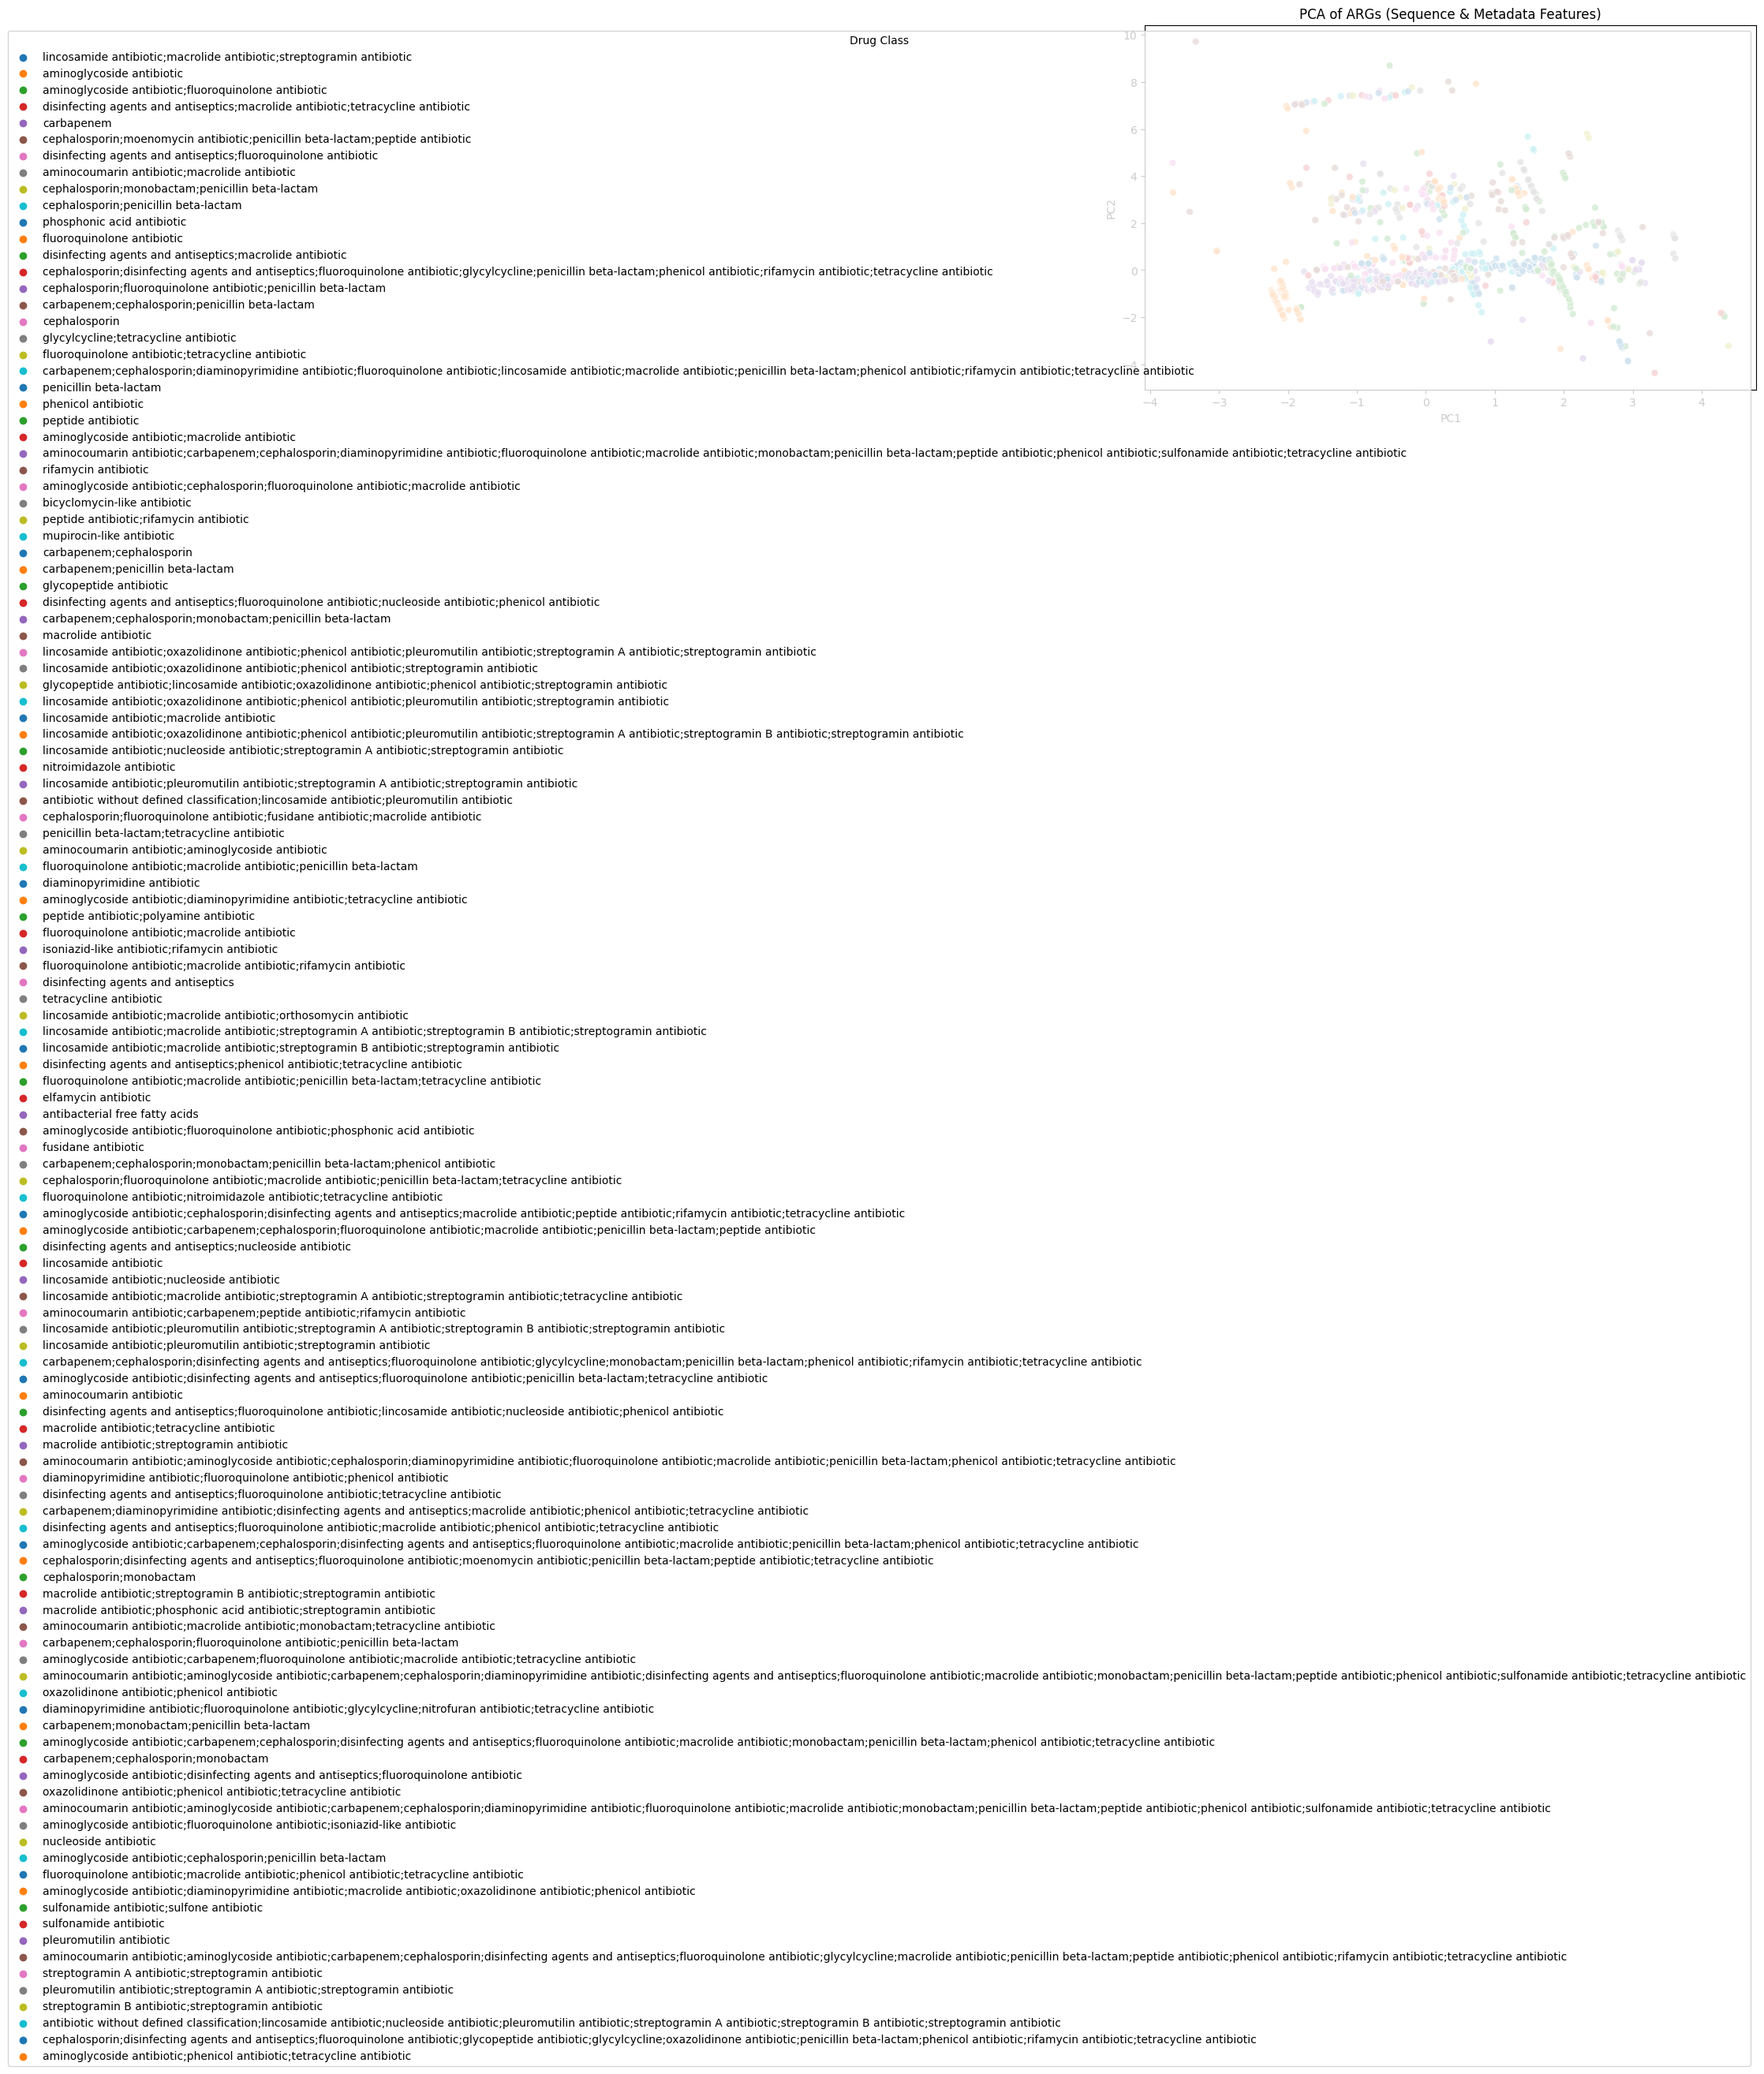

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Encode categorical features
cat_cols = ["AMR Gene Family", "Drug Class", "Resistance Mechanism"]
enc = LabelEncoder()

for col in cat_cols:
    df[col+"_enc"] = enc.fit_transform(df[col].astype(str))

# Feature matrix
X = df[["seq_len", "AMR Gene Family_enc", "Drug Class_enc", "Resistance Mechanism_enc"]]

# Scale
X_scaled = StandardScaler().fit_transform(X)

# PCA to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df["PC1"] = X_pca[:,0]
df["PC2"] = X_pca[:,1]

plt.figure(figsize=(10,6))
sns.scatterplot(
    x="PC1", y="PC2",
    data=df, hue="Drug Class",
    palette="tab10", s=40, alpha=0.8
)
plt.title("PCA of ARGs (Sequence & Metadata Features)")
plt.show()


## Step 17: K-Means Clustering

Applying K-Means clustering algorithm to group ARGs into 4 distinct clusters based on sequence and metadata features.

In [17]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)


## Step 18: Visualize Clusters in PCA Space

**Analysis**: This scatter plot shows how K-Means has partitioned the ARG dataset into 4 distinct clusters. Each cluster represents genes with similar:
- Sequence length characteristics
- Resistance mechanisms
- Drug class associations
- Gene family membership

Well-separated clusters suggest distinct functional or mobility groups. Overlapping regions may indicate genes with hybrid characteristics.

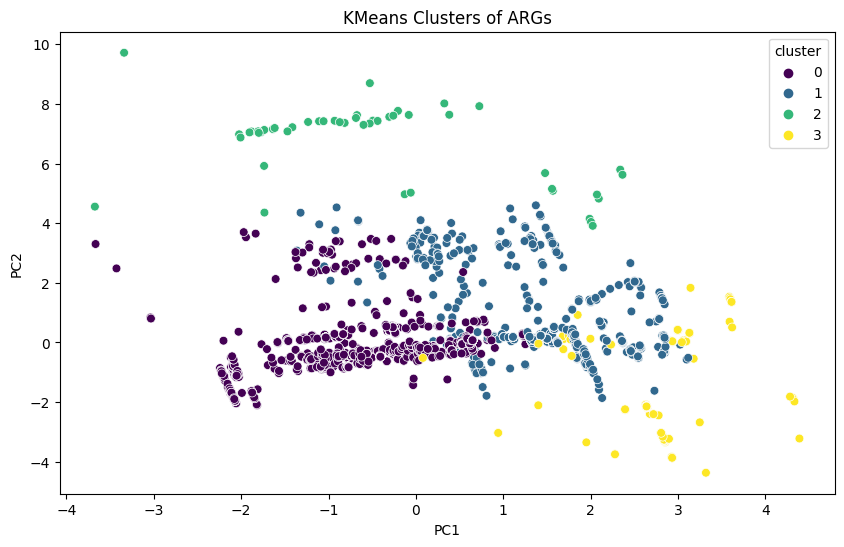

In [18]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df, x="PC1", y="PC2",
    hue="cluster", palette="viridis", s=40
)
plt.title("KMeans Clusters of ARGs")
plt.show()


## Step 19: Cluster Characterization

Analyzing the biological characteristics of each cluster by examining average sequence length and most common features within each group.

In [19]:
cluster_stats = df.groupby("cluster").agg({
    "seq_len": "mean",
    "AMR Gene Family": lambda x: x.value_counts().index[0],
    "Drug Class": lambda x: x.value_counts().index[0],
    "Resistance Mechanism": lambda x: x.value_counts().index[0],
})

cluster_stats


,seq_len,AMR Gene Family,Drug Class,Resistance Mechanism
cluster,,,,
0,315.342352,PDC beta-lactamase,cephalosporin,antibiotic inactivation
1,316.213311,MCR phosphoethanolamine transferase,penicillin beta-lactam,antibiotic inactivation
2,1006.428571,resistance-nodulation-cell division (RND) anti...,peptide antibiotic,antibiotic efflux
3,296.112450,quinolone resistance protein (qnr),fluoroquinolone antibiotic,antibiotic target protection


## Step 20: Define Mobility Scoring Function

Creating a custom scoring algorithm to quantify horizontal gene transfer potential based on:
1. **Sequence length**: Shorter genes are more mobile (score +1)
2. **Mechanism type**: Efflux pumps (+2) and inactivation enzymes (+1) are highly mobile
3. **Gene family**: Beta-lactamases, aminoglycosides, and multidrug resistance genes (+2) are frequently transferred

Higher scores indicate greater mobility risk.

In [20]:
def mobility_score(row):
    score = 0

    # short genes = more mobile
    if row["seq_len"] < df["seq_len"].median():
        score += 1

    # common mobile mechanisms
    if "efflux" in row["Resistance Mechanism"].lower():
        score += 2
    if "inactivation" in row["Resistance Mechanism"].lower():
        score += 1

    # gene families known for HGT
    mobile_families = ["beta-lactamase", "aminoglycoside", "multidrug"]
    for f in mobile_families:
        if f.lower() in row["AMR Gene Family"].lower():
            score += 2

    return score

df["mobility_score"] = df.apply(mobility_score, axis=1)
df[["ARO Name", "mobility_score"]].head()


,ARO Name,mobility_score
0,23S rRNA (adenine(2058)-N(6))-methyltransferas...,1
1,AAC(2')-Ia,2
2,AAC(2')-Ib,2
3,AAC(2')-Ic,2
4,AAC(2')-Id,2


## Step 21: Identify Top High-Risk Mobile Genes

Ranking all ARGs by mobility score to identify the genes with highest horizontal transfer potential. These genes pose the greatest risk for spreading resistance across bacterial populations.

In [21]:
top_mobile = df.sort_values("mobility_score", ascending=False).head(20)
top_mobile[["ARO Accession", "ARO Name", "Drug Class", "Resistance Mechanism", "mobility_score"]]


,ARO Accession,ARO Name,Drug Class,Resistance Mechanism,mobility_score
5012,3004038,Pseudomonas aeruginosa emrE,aminoglycoside antibiotic,antibiotic efflux,5
130,3000768,abeS,aminocoumarin antibiotic;macrolide antibiotic,antibiotic efflux,5
2128,3004580,Klebsiella pneumoniae KpnE,aminoglycoside antibiotic;cephalosporin;disinf...,antibiotic efflux,5
1720,3004039,Escherichia coli emrE,macrolide antibiotic,antibiotic efflux,5
2129,3004583,Klebsiella pneumoniae KpnF,aminoglycoside antibiotic;cephalosporin;disinf...,antibiotic efflux,5
5023,3007015,qacG,disinfecting agents and antiseptics,antibiotic efflux,5
5024,3003836,qacH,disinfecting agents and antiseptics,antibiotic efflux,5
5025,3007014,qacJ,disinfecting agents and antiseptics,antibiotic efflux,5
5026,3005098,qacL,disinfecting agents and antiseptics,antibiotic efflux,5
1261,3005049,CrcB,aminoglycoside antibiotic,antibiotic efflux,5


## Step 22: Mobility Score Distribution

**Analysis**: This histogram shows the distribution of mobility risk scores across all ARGs.

**Key Interpretations**:
- **Low scores (0-2)**: Chromosomally stable genes with low transfer risk
- **Medium scores (3-4)**: Moderate mobility potential
- **High scores (5+)**: High-risk genes frequently found on plasmids and mobile elements

The distribution shape indicates the proportion of genes in each risk category, helping prioritize surveillance efforts.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


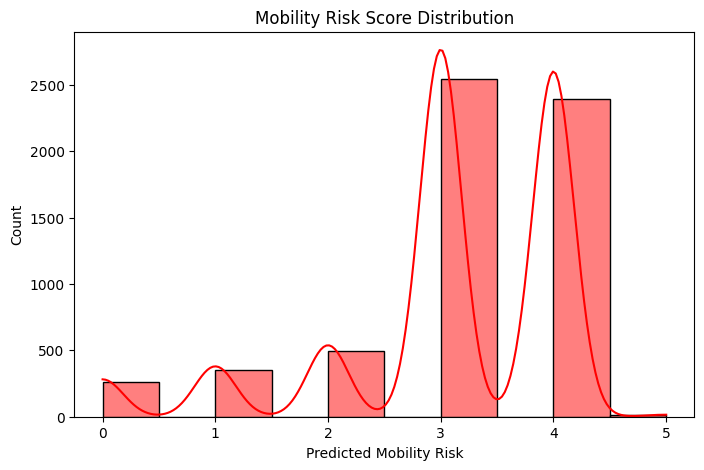

In [22]:
plt.figure(figsize=(8,5))
sns.histplot(df["mobility_score"], bins=10, kde=True, color="red")
plt.title("Mobility Risk Score Distribution")
plt.xlabel("Predicted Mobility Risk")
plt.show()


## Step 23: Summary of Key Insights

Generating a comprehensive summary of the analysis including:
- Most prevalent drug classes under threat
- Common resistance mechanisms
- Cluster characteristics
- Top high-mobility genes requiring surveillance

This summary provides actionable intelligence for AMR monitoring and intervention strategies.

In [23]:
print("=== Insights Summary ===\n")

print("1. Most common drug classes:")
print(df["Drug Class"].value_counts().head(), "\n")

print("2. Most common resistance mechanisms:")
print(df["Resistance Mechanism"].value_counts().head(), "\n")

print("3. Cluster characteristics:")
print(cluster_stats, "\n")

print("4. Top high-mobility genes:")
print(top_mobile[["ARO Name", "Drug Class", "Resistance Mechanism", "mobility_score"]])


=== Insights Summary ===

1. Most common drug classes:
Drug Class
cephalosporin                                      943
carbapenem;penicillin beta-lactam                  820
carbapenem;cephalosporin;monobactam                637
penicillin beta-lactam                             582
carbapenem;cephalosporin;penicillin beta-lactam    578
Name: count, dtype: int64 

2. Most common resistance mechanisms:
Resistance Mechanism
antibiotic inactivation          5240
antibiotic target alteration      285
antibiotic efflux                 269
antibiotic target protection      170
antibiotic target replacement      70
Name: count, dtype: int64 

3. Cluster characteristics:
             seq_len                                    AMR Gene Family  \
cluster                                                                   
0         315.342352                                 PDC beta-lactamase   
1         316.213311                MCR phosphoethanolamine transferase   
2        1006.428571  resi